In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


In [10]:
from datetime import datetime, timedelta

Most Recent Date: 2017-08-23 00:00:00


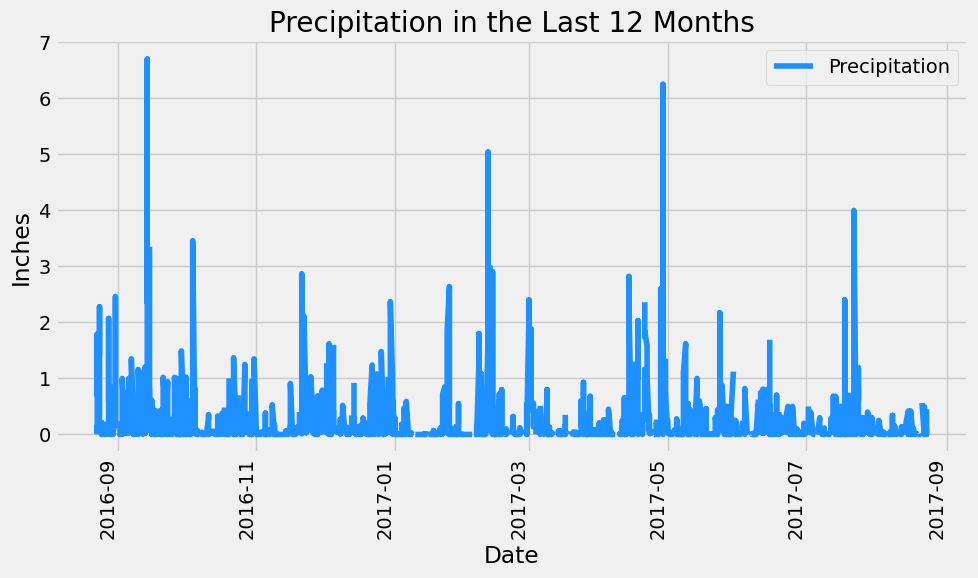

In [31]:
# Step 1: Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
print(f"Most Recent Date: {most_recent_date}")

# Step 2: Calculate the date one year ago from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)

# Step 3: Query the last 12 months of precipitation data (date and prcp only)
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d'))
    .order_by(Measurement.date)
    .all()
)

# Step 4: Load the query results into a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Step 5: Convert the "Date" column to datetime and sort the DataFrame by date
precipitation_df["Date"] = pd.to_datetime(precipitation_df["Date"])
precipitation_df.sort_values(by="Date", inplace=True)

# Step 6: Plot the results using the DataFrame plot method
precipitation_df.set_index("Date", inplace=True)
precipitation_df.plot(
    figsize=(10, 6),
    title="Precipitation in the Last 12 Months",
    xlabel="Date",
    ylabel="Inches",
    color="dodgerblue",
    legend=True,
)
plt.xticks(rotation= 90)
plt.tight_layout()
plt.show()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df["Precipitation"].describe()
precipitation_summary

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Display the result
print(f"Total number of stations in the dataset: {total_stations}")


Total number of stations in the dataset: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Display the results
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")


Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station
most_active_station = session.query(
    Measurement.station,
    func.count(Measurement.station)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

# Query to calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).first()

# Display the results
lowest_temp, highest_temp, avg_temp = temperature_stats
print(f"Most Active Station ID: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


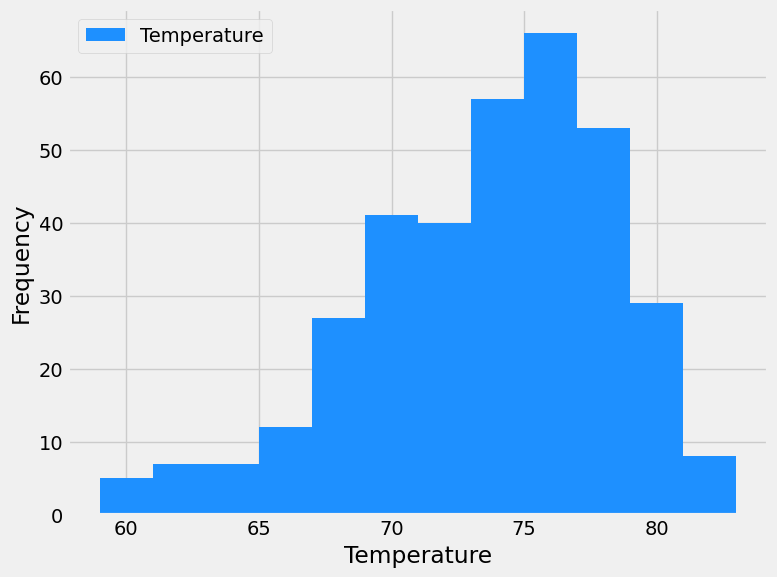

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d'))
    .all()
)

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=["Temperature"])

# Plot the results as a histogram
temperature_df.plot.hist(
    bins=12,
    figsize=(8, 6),
    color='dodgerblue'
)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close Session

In [17]:
# Close Session
session.close()